In [112]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import random,os
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

/kaggle/input/widsdataset/train.csv
/kaggle/input/widsdataset/test.csv
/kaggle/input/widsdataset/sample_solution.csv


In [113]:
train = pd.read_csv("/kaggle/input/widsdataset/train.csv")
test = pd.read_csv("/kaggle/input/widsdataset/test.csv")

In [114]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [115]:
train.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

Finding the Missing Values

In [116]:
# Train 
total_train = train.isnull().sum()
percent_train = (train.isnull().sum())*100/(len(train))
na_train = pd.concat([total_train, percent_train], axis=1, keys=['Total', 'Percent'])
na_train = na_train[na_train['Total']>0]
na_train.sort_values('Total', ascending=False, inplace=True)
print(na_train)

                           Total    Percent
days_with_fog              45796  60.451179
direction_peak_wind_speed  41811  55.190939
direction_max_wind_speed   41082  54.228652
max_wind_speed             41082  54.228652
energy_star_rating         26709  35.256148
year_built                  1837   2.424858


In [117]:
# Test
total_test = test.isnull().sum()
percent_test = (test.isnull().sum())*100/(len(train))
na_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
na_test = na_test[na_test['Total']>0]
na_test.sort_values('Total', ascending=False, inplace=True)
print(na_train)

                           Total    Percent
days_with_fog              45796  60.451179
direction_peak_wind_speed  41811  55.190939
direction_max_wind_speed   41082  54.228652
max_wind_speed             41082  54.228652
energy_star_rating         26709  35.256148
year_built                  1837   2.424858


Taking Out NA values in top 5 because they are such a large percentage 
also taking out ID because it is not useful for this 

In [118]:
TARGET = "site_eui"
ID = "id"

Making a Correlation Matrix with Matplotlib

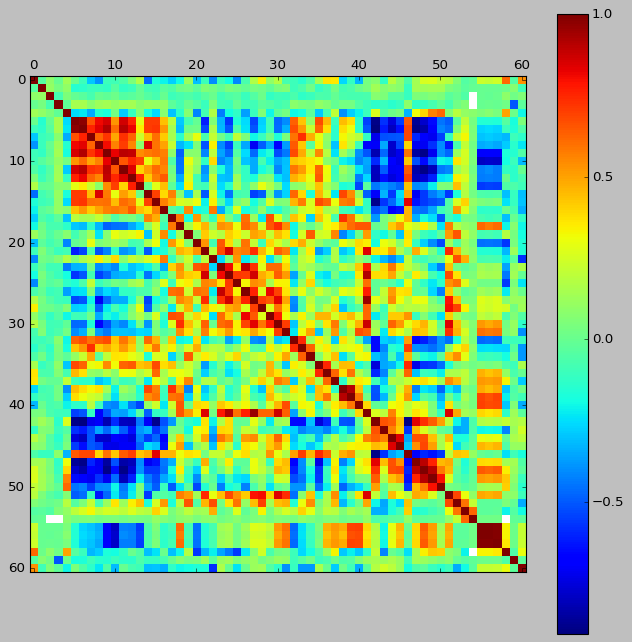

In [119]:
plt.style.use('classic')
fig = plt.figure(figsize=(10, 10))
plt.matshow(train.corr(), fignum=fig.number)
plt.colorbar()
plt.show()

This correlation matrix shows that there are a lot of possitively and negatively correlated features. Might need to address multicollinearity in the model. 

There are also a lot of categorical variables. Let's try a catboost model! 

Building the CAT(boost) Model!
![cat](https://media.wired.co.uk/photos/60c8730fa81eb7f50b44037e/3:2/w_3329,h_2219,c_limit/1521-WIRED-Cat.jpeg)

In [122]:
# Making Sure Which Columns Are Which
cat_columns = train.dtypes[train.dtypes == "object"].index.tolist()
num_columns = train.dtypes[train.dtypes != "object"].index.tolist()
print(cat_columns)

['State_Factor', 'building_class', 'facility_type']


In [127]:
SEED = 7495
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
test_size = 0.2

In [128]:
str_list = [] 
num_list = []
for colname, colvalue in train.iteritems():
    if type(colvalue[1]) == str:
        str_list.append(colname)
    else:
        num_list.append(colname)
        
for col in str_list:
    encoder = LabelEncoder()
    encoder.fit(train[col])
    train[col] = encoder.transform(train[col])

    for label in np.unique(test[col]):
        if label not in encoder.classes_: 
            encoder.classes_ = np.append(encoder.classes_, label) 
    test[col] = encoder.transform(test[col])

In [133]:
X = train.drop([ID, TARGET],axis =1)
y = train[TARGET]

model = CatBoostRegressor(
    verbose=1000,
    early_stopping_rounds=10,
    random_seed=SEED,
    max_depth=12,
    task_type='CPU',
    learning_rate=.025,
    iterations=28000,
    loss_function="RMSE",
    eval_metric= "RMSE"
)
model.fit(X, y)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 57.7666691	total: 236ms	remaining: 1h 50m 12s
1000:	learn: 33.7758881	total: 2m 49s	remaining: 1h 16m 16s
2000:	learn: 29.2674657	total: 5m 37s	remaining: 1h 13m 4s
3000:	learn: 26.4105950	total: 8m 24s	remaining: 1h 10m 4s
4000:	learn: 24.2285064	total: 11m 11s	remaining: 1h 7m 8s
5000:	learn: 22.4515020	total: 13m 57s	remaining: 1h 4m 12s
6000:	learn: 20.9670478	total: 16m 43s	remaining: 1h 1m 19s
7000:	learn: 19.6943180	total: 19m 29s	remaining: 58m 27s
8000:	learn: 18.6093826	total: 22m 15s	remaining: 55m 38s
9000:	learn: 17.6961994	total: 25m 3s	remaining: 52m 53s
10000:	learn: 16.8971187	total: 27m 50s	remaining: 50m 5s
11000:	learn: 16.1764952	total: 30m 36s	remaining: 47m 17s
12000:	learn: 15.5421166	total: 33m 23s	remaining: 44m 30s
13000:	learn: 14.9734482	total: 36m 10s	remaining: 41m 44s
14000:	learn: 14.4315039	total: 38m 56s	remaining: 38m 56s
15000:	learn: 13.9453091	total: 41m 43s	remaining: 36m 9s
16000:	learn: 13.5152102	total: 44m 30s	remaining: 33m 22s
170

In [134]:
X_test = test.drop([ID],axis=1)
pred_test = model.predict(X_test)

In [138]:
sub = pd.read_csv("/kaggle/input/widsdataset/sample_solution.csv")
sub[TARGET] = pred_test
sub.to_csv("submission_2.csv",index=False)
sub.head()

,id,site_eui
0,75757,240.334724
1,75758,253.185938
2,75759,189.587628
3,75760,244.820407
4,75761,236.098144


This is my catboost model! Let's submit and see what happens! :) 
![catboost](https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-girl-cat-names-1606245046.jpg?crop=0.668xw:1.00xh;0.126xw,0&resize=640:*)